In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


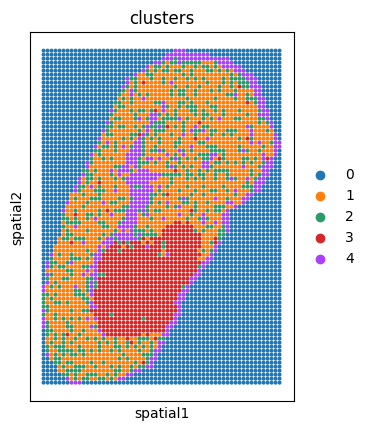

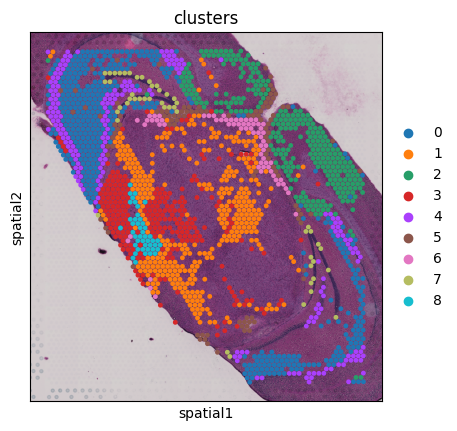

In [2]:
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_FMP_VisiumArray.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_visium_FMP.h5ad")
sc.pl.spatial(adata1, img_key = "hires", color="clusters", spot_size=1)
sc.pl.spatial(adata2, img_key = "hires", color="clusters", size=1.5)
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]

In [3]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_visium_FMP__m4_FMP_VisiumArray\\groundtruth.csv')

# Display the first few rows of the DataFrame
print(df.head())

   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0      21.686753      30.508586           0                0             -1   
1      57.831324      30.508449           1                0             -1   
2     125.301205      40.677972           2                2             -1   
3     180.722894     118.644104           3                0             -1   
4      55.421686     115.254214           4                3             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0        21.686747        30.508475           353                  2   
1        57.831325        30.508475           338                  1   
2       125.301205        40.677966           476                  2   
3       180.722892       118.644068          2091                  1   
4        55.421687       115.254237          2076                  3   

   matabolic.CCA.Z  
0                1  
1                1  
2                1  
3       

In [4]:
from scipy.sparse import issparse
adata1.X.shape
adata3=adata1[df["matabolic_ID"].to_numpy()]
adata4 = csr_matrix(adata3.X)
print(np.mean(adata3.X, axis=0))
print(np.mean(adata2.X, axis=0))

[1.36292244 1.25527316 0.97417072 ... 0.88029571 0.6889179  0.72501166]
[[0.00445921 0.01012757 0.00767953 ... 0.04683544 0.00978254 0.3048889 ]]


In [5]:
adata2.obs["cell_ID"] = "A"

In [6]:
adata2.obsm["spatial"]

array([[ 9154,  3925],
       [16990,  5404],
       [31805, 10888],
       ...,
       [22040, 32124],
       [21739, 29603],
       [ 5432, 14538]], dtype=int64)

In [7]:
adata5 = sc.AnnData(X=adata4, var=adata1.var, obs=adata2.obs)
import harmonypy as hm
#sc.pp.log1p(adata2)
sc.pp.scale(adata2, max_value=10)
sc.tl.pca(adata2, svd_solver='arpack')
#sc.pp.log1p(adata5)
sc.pp.scale(adata5, max_value=10)
sc.tl.pca(adata5, svd_solver='arpack')
pca_rna = adata2.obsm['X_pca']
pca_atac = adata5.obsm['X_pca']
data_mat = np.concatenate([pca_rna, pca_atac],axis=1)
harmony_result = hm.run_harmony(data_mat, adata2.obs,"cell_ID")
adata_combined = sc.AnnData(X=harmony_result.Z_corr.T)
adata_combined.obs = adata2.obs

2024-06-26 21:08:15,256 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-26 21:08:16,241 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-26 21:08:16,249 - harmonypy - INFO - Iteration 1 of 10
2024-06-26 21:08:16,573 - harmonypy - INFO - Iteration 2 of 10
2024-06-26 21:08:16,841 - harmonypy - INFO - Iteration 3 of 10
2024-06-26 21:08:17,015 - harmonypy - INFO - Converged after 3 iterations


C:\Users\28123\AppData\Local\Temp\ipykernel_5368\2997282667.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_combined)


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

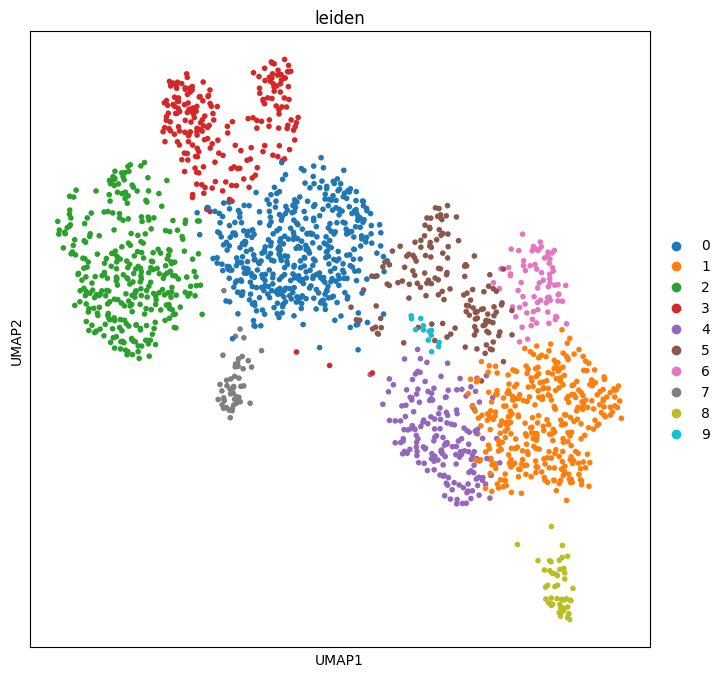

In [8]:
sc.pp.neighbors(adata_combined, n_neighbors=50, use_rep='X')
sc.tl.umap(adata_combined)
sc.tl.leiden(adata_combined)
fig, ax = plt.subplots(figsize=(8, 8))  # 设置图像大小为 10x8 英寸
sc.pl.umap(adata_combined, color=['leiden'], ax=ax, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\umap_merge.pdf")


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

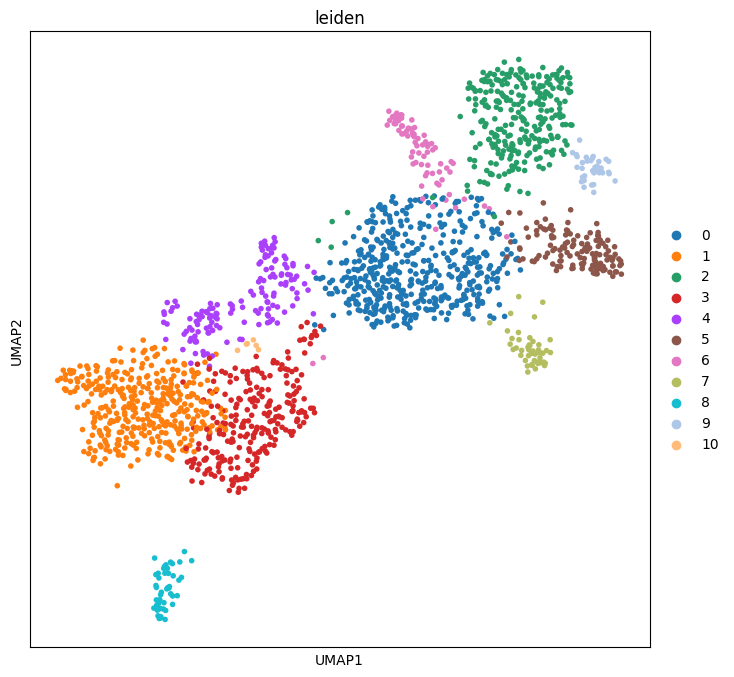

In [9]:
sc.pp.neighbors(adata2, n_neighbors=50)
sc.tl.umap(adata2)
fig, ax = plt.subplots(figsize=(8, 8))  # 设置图像大小为 10x8 英寸
sc.tl.leiden(adata2)
sc.pl.umap(adata2, color=['leiden'], ax=ax, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\umap_transcript.pdf")


<Axes: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

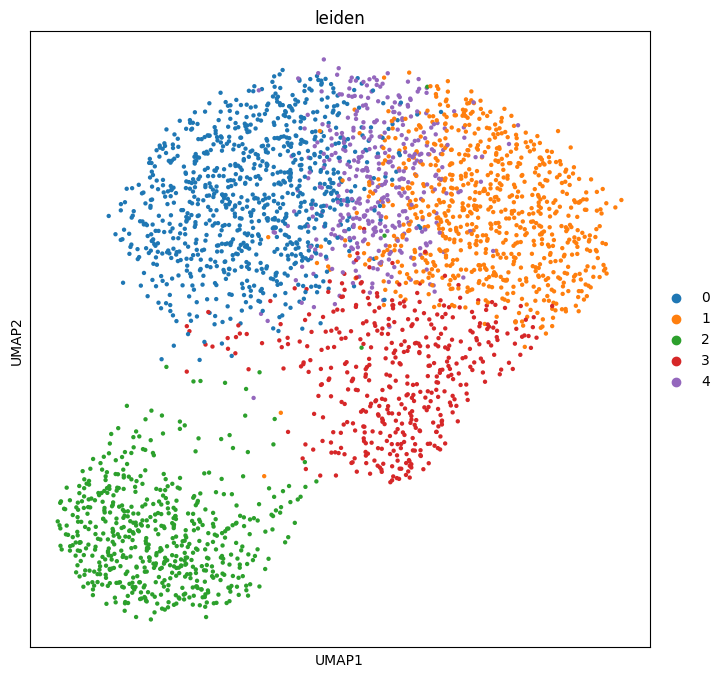

In [10]:
sc.pp.neighbors(adata1, n_neighbors=50)
sc.tl.umap(adata1)
fig, ax = plt.subplots(figsize=(8, 8))  # 设置图像大小为 10x8 英寸
sc.tl.leiden(adata1)
sc.pl.umap(adata1, color=['leiden'], ax=ax, show=False)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\umap_metabolic.pdf")

In [11]:
from scipy.sparse import vstack, hstack
if adata2.shape[0] != adata3.shape[0]:
    raise ValueError("细胞数量不匹配，无法合并")
    
combined_X = hstack([adata2.X, adata4])

# 更新基因名称
combined_var_names = np.concatenate([adata2.var_names, adata3.var_names])

# 创建新的 AnnData 对象
combined_adata = sc.AnnData(X=combined_X, var=pd.DataFrame(index=combined_var_names), obs=adata2.obs)
#combined_adata = sc.AnnData(X=adata4, var=pd.DataFrame(index=adata3.var_names), obs=adata2.obs)
# 打印合并后的 AnnData 对象的维度
print(combined_adata.shape) 

(1841, 15005)


In [12]:
adata =sc.AnnData(combined_adata.X)

adata.obs = combined_adata.obs
adata.obsm = adata2.obsm
adata.var = pd.DataFrame({
    'gene_ids': adata.var_names,
})
adata.var_names = combined_adata.var_names

In [13]:
adata.uns=adata2.uns

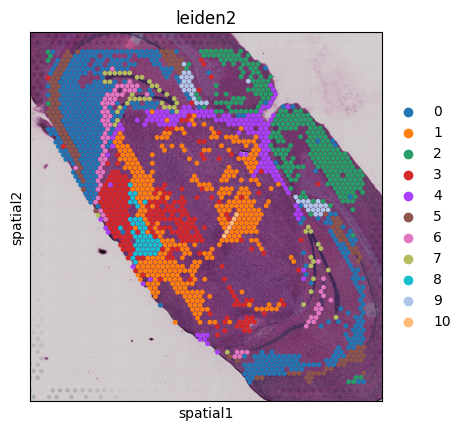

In [14]:
adata.obs["leiden2"] = adata_combined.obs["leiden"]

sc.pl.spatial(adata, img_key = "hires", color="leiden2", size=1.5)

In [15]:
adata_combined.obs["leiden"].astype(int).tolist()

[0,
 0,
 2,
 0,
 3,
 1,
 5,
 1,
 5,
 0,
 2,
 7,
 0,
 2,
 1,
 3,
 0,
 2,
 9,
 3,
 2,
 6,
 5,
 4,
 0,
 2,
 3,
 1,
 3,
 4,
 3,
 0,
 2,
 3,
 0,
 9,
 3,
 2,
 0,
 4,
 0,
 1,
 8,
 1,
 0,
 0,
 2,
 1,
 5,
 5,
 0,
 3,
 1,
 0,
 6,
 4,
 1,
 0,
 3,
 0,
 0,
 0,
 7,
 1,
 1,
 3,
 1,
 6,
 4,
 7,
 1,
 2,
 0,
 4,
 5,
 0,
 1,
 0,
 1,
 3,
 3,
 0,
 3,
 3,
 3,
 0,
 0,
 1,
 2,
 1,
 0,
 7,
 6,
 2,
 3,
 7,
 7,
 0,
 0,
 1,
 0,
 2,
 3,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 3,
 3,
 1,
 2,
 4,
 0,
 2,
 5,
 0,
 1,
 9,
 9,
 2,
 1,
 3,
 8,
 0,
 2,
 1,
 4,
 1,
 9,
 0,
 0,
 9,
 3,
 3,
 0,
 1,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 3,
 2,
 3,
 0,
 6,
 2,
 0,
 1,
 3,
 0,
 3,
 2,
 4,
 2,
 10,
 2,
 1,
 3,
 2,
 0,
 0,
 2,
 7,
 2,
 0,
 0,
 7,
 2,
 1,
 2,
 1,
 0,
 9,
 2,
 0,
 9,
 5,
 2,
 6,
 1,
 3,
 0,
 0,
 1,
 1,
 2,
 1,
 4,
 1,
 0,
 0,
 2,
 10,
 2,
 0,
 1,
 1,
 3,
 5,
 2,
 6,
 0,
 0,
 1,
 4,
 0,
 3,
 0,
 3,
 5,
 7,
 2,
 3,
 0,
 8,
 3,
 1,
 0,
 3,
 6,
 1,
 3,
 1,
 0,
 3,
 4,
 2,
 5,
 0,
 1,
 1,
 1,
 2,
 0

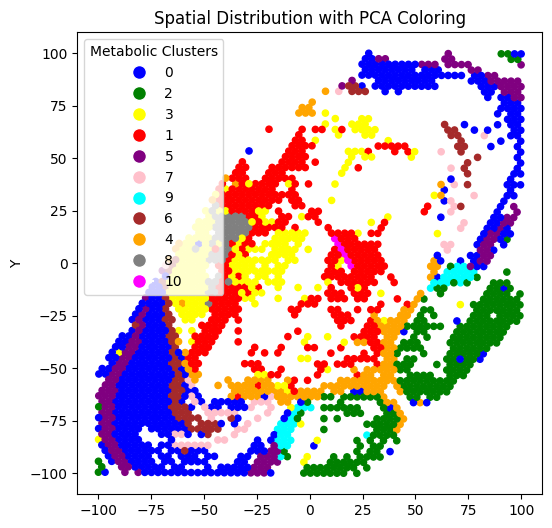

In [15]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-100, 100))
data_spatial_results = pd.DataFrame(adata2.obsm['spatial'])

data_spatial_results = scaler.fit_transform(data_spatial_results)
data_spatial_results = pd.DataFrame(data_spatial_results)

color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

plt.figure(figsize=(6, 6),facecolor='white')
plt.grid(False)
unique_categories = adata_combined.obs["leiden"].astype(int).unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[cat], markersize=10) for cat in unique_categories]
plt.scatter(data_spatial_results.iloc[:, 0],data_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in adata_combined.obs["leiden"].astype(int).tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')

plt.legend(handles, unique_categories, title="Metabolic Clusters")
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\m4_visium_FMP__m4_FMP_VisiumArray\\m4_visium_FMP__m4_FMP_VisiumArray_merge.pdf")
plt.show()

In [16]:
adata.X = adata.X.toarray()

In [17]:
adata5 = sc.AnnData(X=adata4, var=adata1.var, obs=adata2.obs)

In [18]:
adata2

AnnData object with n_obs × n_vars = 1841 × 13467
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden', 'cell_ID'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'leiden', 'leiden_colors', 'leiden2_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
I:\mutiomics\pythonProject\.venv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
I:\mutiomics\pythonProjec

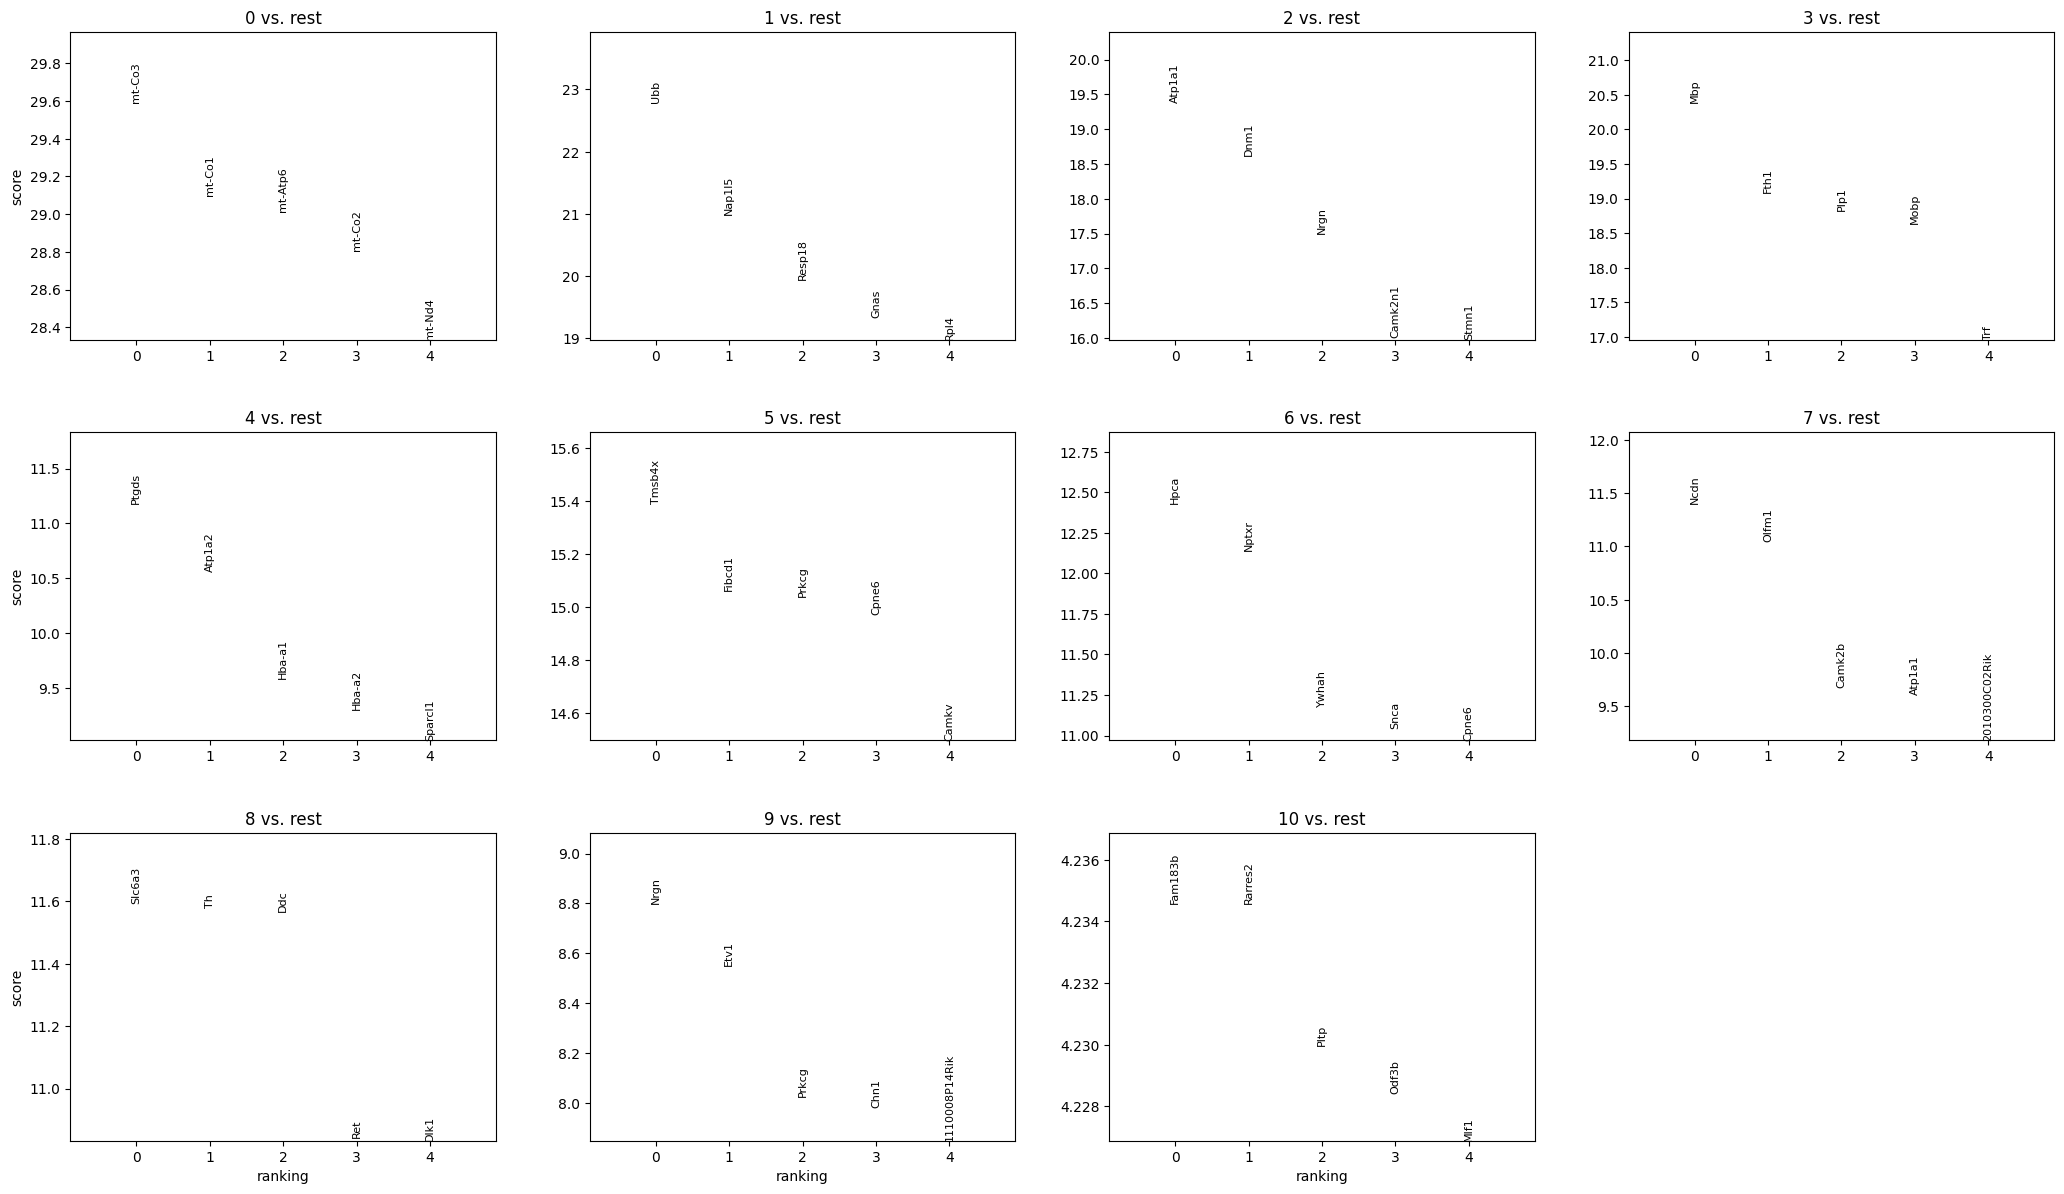

In [19]:
#adata5 = sc.AnnData(X=adata4, var=adata1.var, obs=adata.obs)
adata5 = sc.AnnData(X=adata2.X, var=adata2.var, obs=adata.obs)
adata5.obsm = adata.obsm
adata5.uns = adata.uns

sc.tl.rank_genes_groups(adata5, 'leiden2', method='wilcoxon', n_genes=200)

# 查看结果

# 可视化结果
sc.pl.rank_genes_groups(adata5, n_genes=5, sharey=False)

In [20]:
filtered_var_names = [name for name in adata1.var_names if "435.2" in name]

# 打印结果
print(filtered_var_names)

['435.20692']


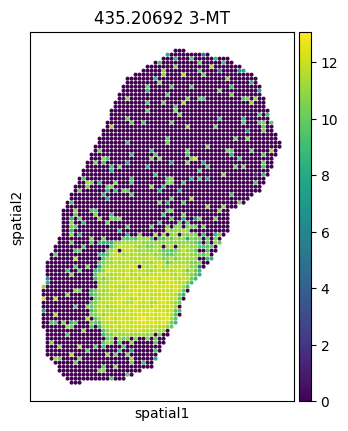

In [44]:
sc.pl.spatial(
    adata1,
    color="435.20692",
    title="435.20692 3-MT",
    size=1,spot_size = 1,
    show=False
)
#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\3-MT_metabolic.pdf")
plt.show()  # 显示图像，确保图像已经正确绘制

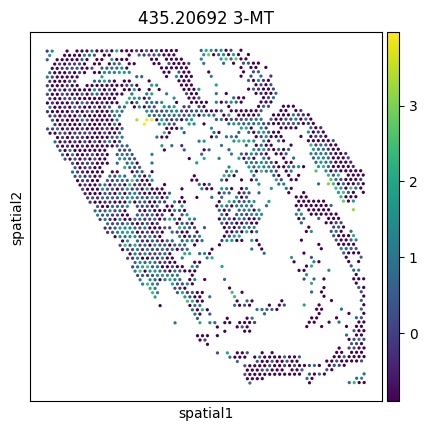

In [21]:
sc.pl.spatial(
    adata,
    color="Pcp4",
    title="435.20692 3-MT",
    size=1,
    show=False, alpha_img=0
)

#plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\3-MTtranscript.pdf")
plt.show()  # 显示图像，确保图像已经正确绘制

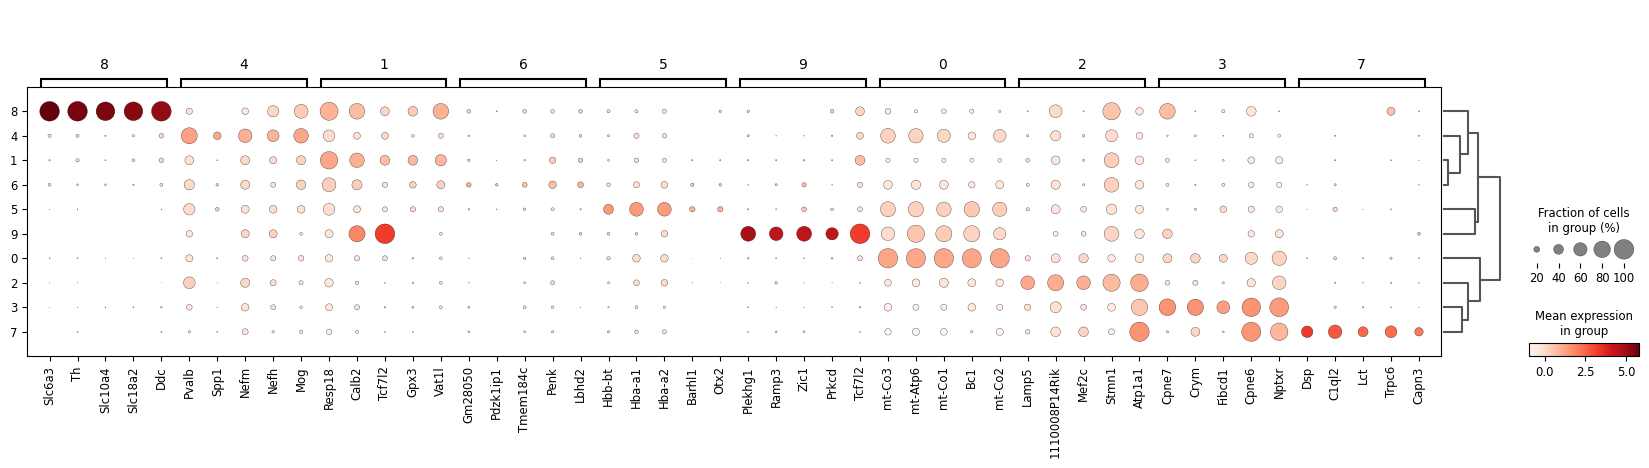

In [36]:
sc.tl.rank_genes_groups(adata5, 'leiden2', method='logreg')
# 绘制热图
#sc.pl.rank_genes_groups_heatmap(adata5, n_genes=20, groupby='leiden2', show_gene_labels=True)
# 绘制点图
sc.pl.rank_genes_groups_dotplot(adata5, n_genes=5, groupby='leiden2', show=False)
plt.savefig("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\marker_transcript.pdf")
plt.show()  # 显示图像，确保图像已经正确绘制

In [55]:
list2 = ["C"+str(i) for i in adata_combined.obs["leiden"].astype(int).tolist()]
list1 = ["M"+str(i) for i in adata1[df["matabolic_ID"].to_numpy()].obs["clusters"].astype(int).tolist()]
list3 = ["S"+str(i) for i in adata2.obs["clusters"].astype(int).tolist()]

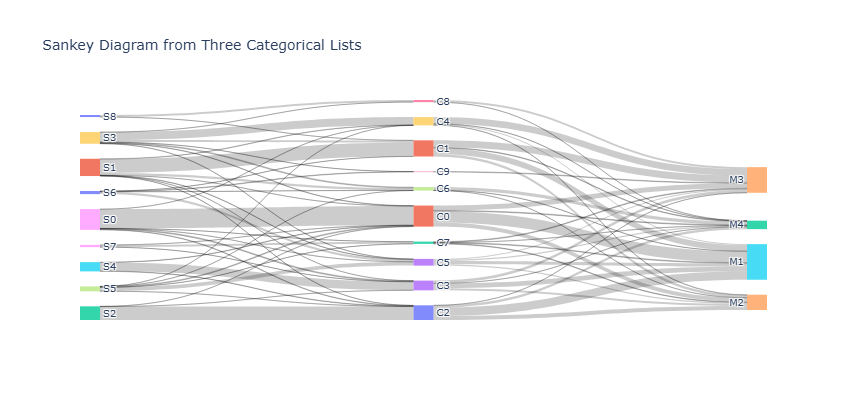

In [57]:
import plotly.graph_objects as go
from collections import Counter
import pandas as pd
# 假设有三个列表，每个列表包含分类变量

# 创建所有唯一节点的集合
labels = list(set(list1 + list2 + list3))

# 创建节点的索引
label_to_index = {label: index for index, label in enumerate(labels)}

# 创建源和目标列表
source_indices = []
target_indices = []
value_list = []

# 填充源和目标列表，计算每个连接的值
for i in range(len(list1)):
    source_indices.append(label_to_index[list1[i]])
    target_indices.append(label_to_index[list2[i]])
    value_list.append(1)  # 假设每个连接的权重为1，可以根据需要调整

for i in range(len(list2)):
    source_indices.append(label_to_index[list2[i]])
    target_indices.append(label_to_index[list3[i]])
    value_list.append(1)  # 假设每个连接的权重为1，可以根据需要调整

combinations = list(zip(target_indices, source_indices))

# 统计每种组合的个数
combination_counts = Counter(combinations)

# 将结果转换为更易读的格式
combination_counts_list = [{"Combination": comb, "Count": count} for comb, count in combination_counts.items()]

# 打印结果
value_list = [item['Count'] for item in combination_counts_list]
source_indices = [item['Combination'][0] for item in combination_counts_list]
target_indices = [item['Combination'][1] for item in combination_counts_list]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="rgba(200, 200, 200, 0.01)",width=0.1),
        label=labels
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=value_list
    )
)])
fig.update_layout(
    title_text="Sankey Diagram",
    font_size=10,
    width=400,  # 调整图表宽度
    height=400  # 调整图表高度
)
# 添加标题
fig.update_layout(title_text="Sankey Diagram from Three Categorical Lists", font_size=10)

# 显示图表
fig.show()

fig.write_image("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\m4\\sankey_diagram.pdf")

In [154]:
from collections import Counter
print(target_indices[1:10])
print(source_indices[1:10])


[2, 15, 2, 2, 15, 18, 11, 4, 11]
[17, 10, 10, 10, 3, 10, 1, 1, 1]


[2,
 2,
 15,
 15,
 18,
 11,
 4,
 2,
 13,
 2,
 13,
 15,
 18,
 15,
 2,
 15,
 18,
 13,
 18,
 13,
 5,
 6,
 8,
 9,
 7,
 5,
 8,
 6,
 9,
 14,
 16,
 16,
 7,
 14,
 14,
 14,
 7,
 14,
 6,
 14,
 8,
 7,
 9]